In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [3]:
!unzip "/content/drive/MyDrive/Dataset/lung_colon_image_set.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/lung_colon_image_set/lung_scc/lungscc571.jpeg  
  inflating: /content/__MACOSX/lung_colon_image_set/lung_scc/._lungscc571.jpeg  
  inflating: /content/lung_colon_image_set/lung_scc/lungscc4063.jpeg  
  inflating: /content/__MACOSX/lung_colon_image_set/lung_scc/._lungscc4063.jpeg  
  inflating: /content/lung_colon_image_set/lung_scc/lungscc1261.jpeg  
  inflating: /content/__MACOSX/lung_colon_image_set/lung_scc/._lungscc1261.jpeg  
  inflating: /content/lung_colon_image_set/lung_scc/lungscc4599.jpeg  
  inflating: /content/__MACOSX/lung_colon_image_set/lung_scc/._lungscc4599.jpeg  
  inflating: /content/lung_colon_image_set/lung_scc/lungscc121.jpeg  
  inflating: /content/__MACOSX/lung_colon_image_set/lung_scc/._lungscc121.jpeg  
  inflating: /content/lung_colon_image_set/lung_scc/lungscc4433.jpeg  
  inflating: /content/__MACOSX/lung_colon_image_set/lung_scc/._lungscc4433.jpeg  
  inflating: /content/lung_colon_im

In [4]:
sdir=r'/content/lung_colon_image_set'
slist=os.listdir(sdir)
classes=[]
filepaths=[]
labels=[]
for d in slist:
    dpath=os.path.join(sdir, d)
    if os.path.isdir(dpath):
        classes.append(d)
class_count=len(classes)
for klass in classes:
    classpath=os.path.join(sdir,klass)
    filelist=os.listdir(classpath)
    for f in filelist:
        fpath=os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)
print ('number of files: ', len(filepaths), '   number of labels: ', len(labels))
file_series=pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)
print (df.head())

number of files:  25000    number of labels:  25000
                                           filepaths    labels
0  /content/lung_colon_image_set/lung_scc/lungscc...  lung_scc
1  /content/lung_colon_image_set/lung_scc/lungscc...  lung_scc
2  /content/lung_colon_image_set/lung_scc/lungscc...  lung_scc
3  /content/lung_colon_image_set/lung_scc/lungscc...  lung_scc
4  /content/lung_colon_image_set/lung_scc/lungscc...  lung_scc


In [5]:
balance=df['labels'].value_counts()
print (balance)
# Removed Classes : Vitiligo, Impetigo, Hives, Ringworm, Rosaca

labels
lung_scc     5000
colon_aca    5000
lung_n       5000
lung_aca     5000
colon_n      5000
Name: count, dtype: int64


In [6]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=125)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=125)
print ('train size: ', len(train_df), '  test size: ', len(test_df), '   valid size: ', len(valid_df))
length=len(test_df)

train size:  20000   test size:  2500    valid size:  2500


In [7]:
batch_size=32
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(448,448), class_mode='categorical',
                                   batch_size=batch_size, shuffle=True, seed=123)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(448,448), class_mode='categorical',
                                   batch_size=batch_size, shuffle=False)
# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(448,448), class_mode='categorical',
                                   batch_size=test_batch_size, shuffle=False)
test_labels=test_gen.labels

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [8]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [9]:
img_shape=(448,448,3)
neurons=512
dropout=.3
lr=.001
freeze=True
base_model=tf.keras.applications.VGG16(include_top=False, input_shape=img_shape, pooling='max', weights='imagenet')
if freeze:
    base_model.trainable=False
x=base_model.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x =tf.keras.layers.Dense(neurons, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x=tf.keras.layers.Dropout(rate=dropout, seed=123)(x)
output=tf.keras.layers.Dense(class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 4s 0us/step


In [10]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [11]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,end_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        self.count=0 # initialize counter that counts epochs with no improvement
        self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.end_epoch=end_epoch # value of the number of epochs to run
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '
        print_in_color (msgs, (244, 252, 3), (55,65,80))

    def on_epoch_begin(self, epoch, logs=None): # just used to print data from previous epoch
        if epoch != 0:
            msgs=f'for epoch {epoch} '
            msgs=msgs + LRA.msg
            print_in_color(msgs, (255,255,0), (55,65,80))

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                LRA.msg= f' training accuracy improved from  {self.highest_tracc:7.4f} to {acc:7.4f} learning rate held at {lr:10.8f}'
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                    msgs=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    LRA.msg=msgs + f' for {self.patience } epochs, lr adjusted to {self.lr:10.8f}'
                else:
                    self.count=self.count +1 # increment patience counter
                    LRA.msg=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    #print_in_color(msg, (255,255,0), (55,65,80))
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                msgs=f' validation loss improved from {self.lowest_vloss:8.5f} to {v_loss:8.5}, saving best weights'
                LRA.msg=msgs + f' learning rate held at {self.lr:10.8f}'
                #print_in_color(msg, (0,255,0), (55,65,80))
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    msgs=f' val_loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f} for {self.patience} epochs'
                    LRA.msg=msgs + f', lr adjusted to {self.lr:10.8f}'
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                    LRA.msg=f' validation loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f}'
                    #print_in_color(msg, (255,255,0), (55,65,80))
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        if epoch==self.end_epoch:
            print_in_color(LRA.msg, (255,255,0), (55,65,80)) # print out data for the final epoch
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            LRA.msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(LRA.msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [12]:
patience=1
stop_patience=4
threshold=.9
factor=.5
dwell=False
model_type='VGG16'
epochs=8
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_type, freeze=freeze, end_epoch=epochs - 1 )]

 Starting training using  base model VGG16 with weights frozen to imagenet weights initializing LRA callback



In [13]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/8
625/625 [==============================] - 385s 577ms/step - loss: 3.0781 - accuracy: 0.9387 - val_loss: 0.7524 - val_accuracy: 0.9652
for epoch 1  validation loss improved from      inf to  0.75237, saving best weights learning rate held at 0.00100000

Epoch 2/8
625/625 [==============================] - 359s 574ms/step - loss: 0.4857 - accuracy: 0.9607 - val_loss: 0.3426 - val_accuracy: 0.9680
for epoch 2  validation loss improved from  0.75237 to  0.34262, saving best weights learning rate held at 0.00100000

Epoch 3/8
625/625 [==============================] - 358s 573ms/step - loss: 0.3243 - accuracy: 0.9639 - val_loss: 0.2696 - val_accuracy: 0.9748
for epoch 3  validation loss improved from  0.34262 to  0.26956, saving best weights learning rate held at 0.00100000

Epoch 4/8
625/625 [==============================] - 360s 576ms/step - loss: 0.2767 - accuracy: 0.9670 - val_loss: 0.2573 - val_accuracy: 0.9656
for epoch 4  validation loss improved from  0.26956 to   0.2573

In [14]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

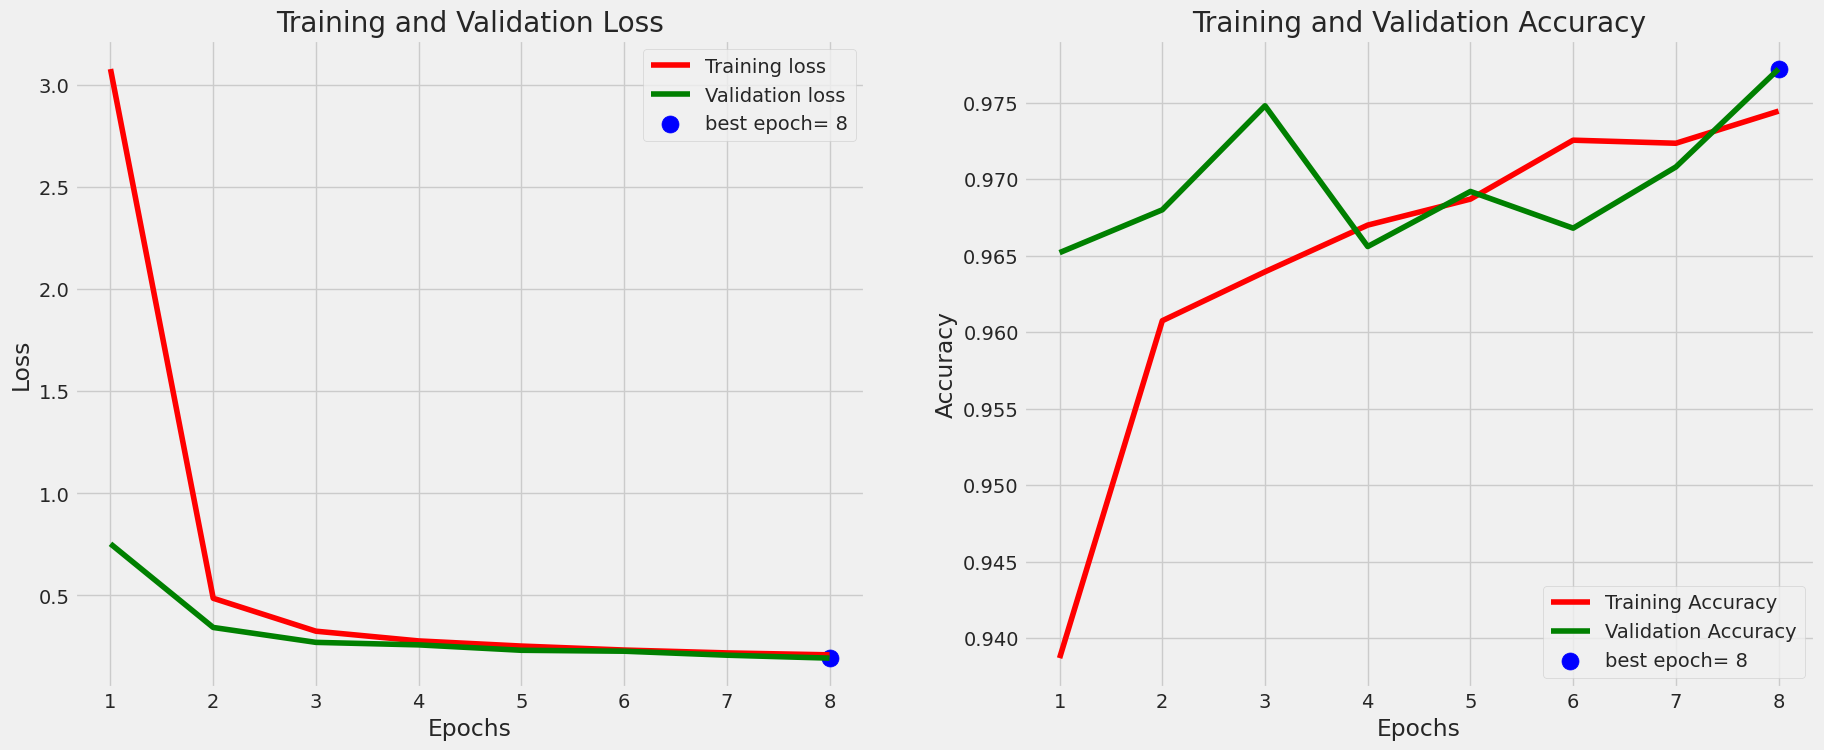

In [15]:
tr_plot(history, 0)

for epoch 8  validation loss improved from  0.20674 to  0.19237, saving best weights learning rate held at 0.00100000

Epoch 9/10
625/625 [==============================] - 359s 575ms/step - loss: 0.2014 - accuracy: 0.9746 - val_loss: 0.1868 - val_accuracy: 0.9780
for epoch 9  validation loss improved from  0.19237 to  0.18679, saving best weights learning rate held at 0.00100000

Epoch 10/10
625/625 [==============================] - 359s 575ms/step - loss: 0.1904 - accuracy: 0.9773 - val_loss: 0.1722 - val_accuracy: 0.9792


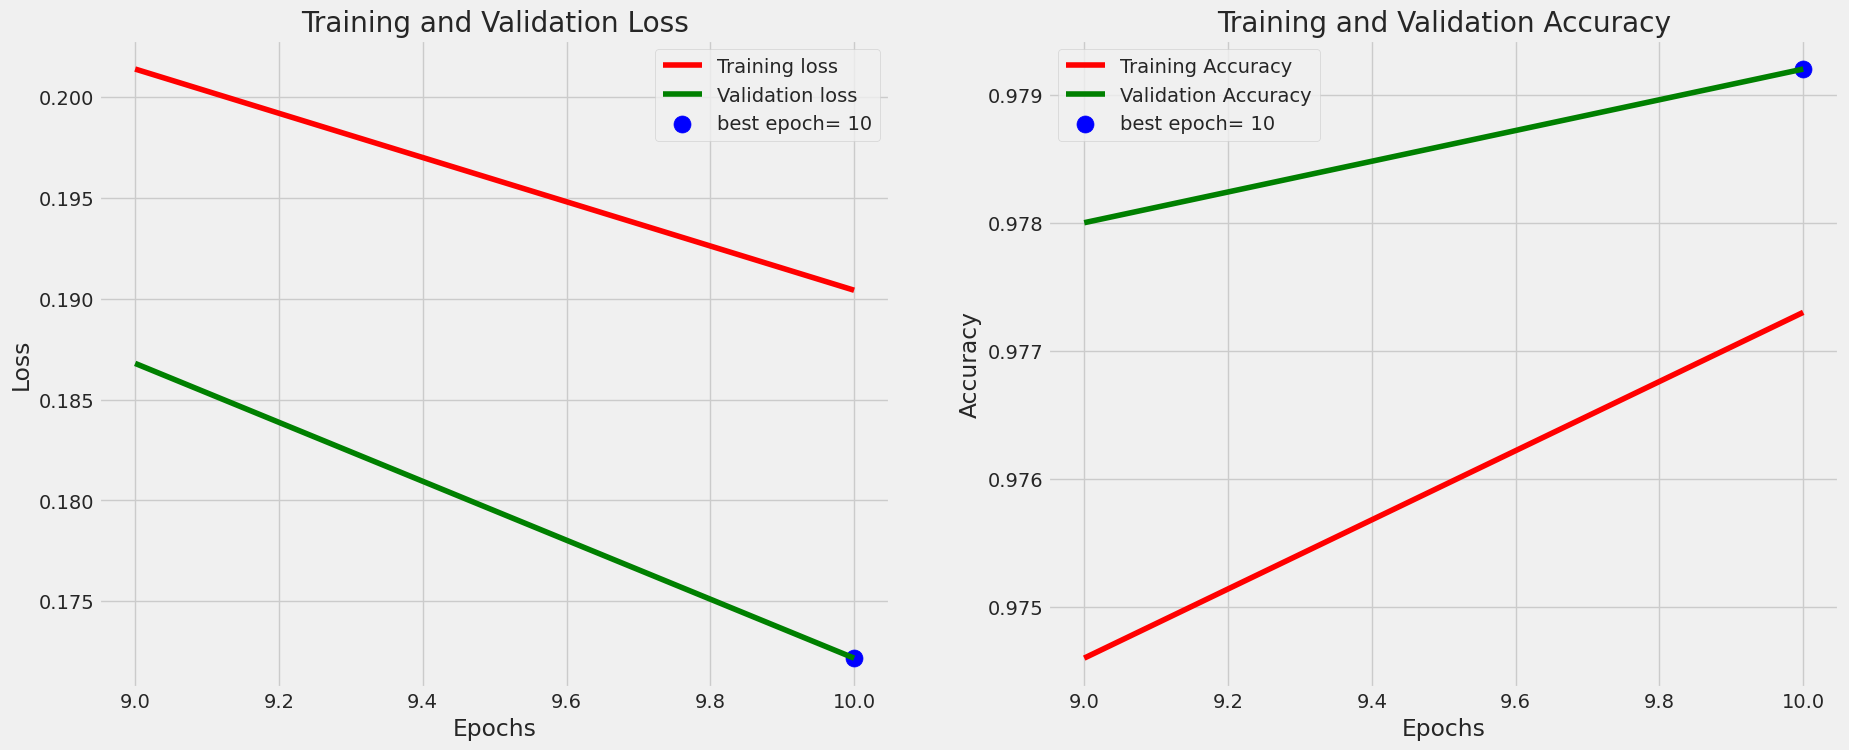

In [16]:
base_model.trainable=True
fine_tune_epochs=2
total_epochs=epochs + fine_tune_epochs
history=model.fit(x=train_gen,  epochs=total_epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=epochs)
tr_plot(history,epochs)

In [ ]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    print_in_color(msg, (255,255,0), (55,65,80))
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    print_in_color(msg, (255,255,0), (55,65,80))
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

In [ ]:
subject='Disease 2'
save_dir = r'./'
e_dict=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=True)
acc=display_eval_metrics(e_dict)
msg=f'Accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_type +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)
preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=None)

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    if len(classes)<= 20:
        # create a confusion matrix and a test report
        y_true= np.array(labels)
        y_pred=np.array(y_pred)
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width=length
            fig_height=length
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        print("Classification Report:\n----------------------\n", clr)

          Filename                Predicted Class                True Class           Probability   

/content/lung_colon_image_set/lung_scc/lungscc1751.jpeg          lung_aca                    lung_scc              0.6926

/content/lung_colon_image_set/lung_n/lungn3138.jpeg          lung_aca                     lung_n               0.6633

/content/lung_colon_image_set/lung_scc/lungscc812.jpeg          lung_aca                    lung_scc              0.9666

/content/lung_colon_image_set/colon_aca/colonca2346.jpeg          lung_aca                   colon_aca              0.8916

/content/lung_colon_image_set/lung_aca/lungaca3628.jpeg          lung_scc                    lung_aca              0.6993

/content/lung_colon_image_set/colon_n/colonn2801.jpeg         colon_aca                    colon_n               0.6238

/content/lung_colon_image_set/lung_aca/lungaca1836.jpeg          lung_scc                    lung_aca              0.6879

/content/lung_colon_image_set/lung_scc/lung

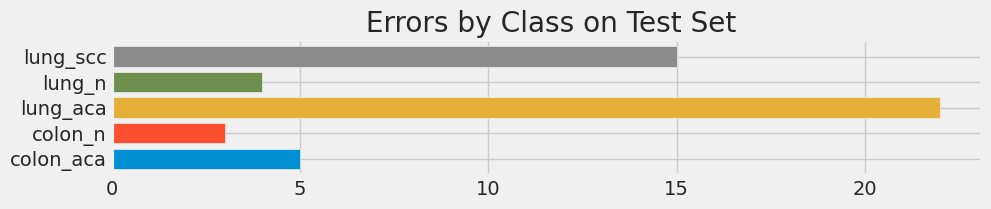

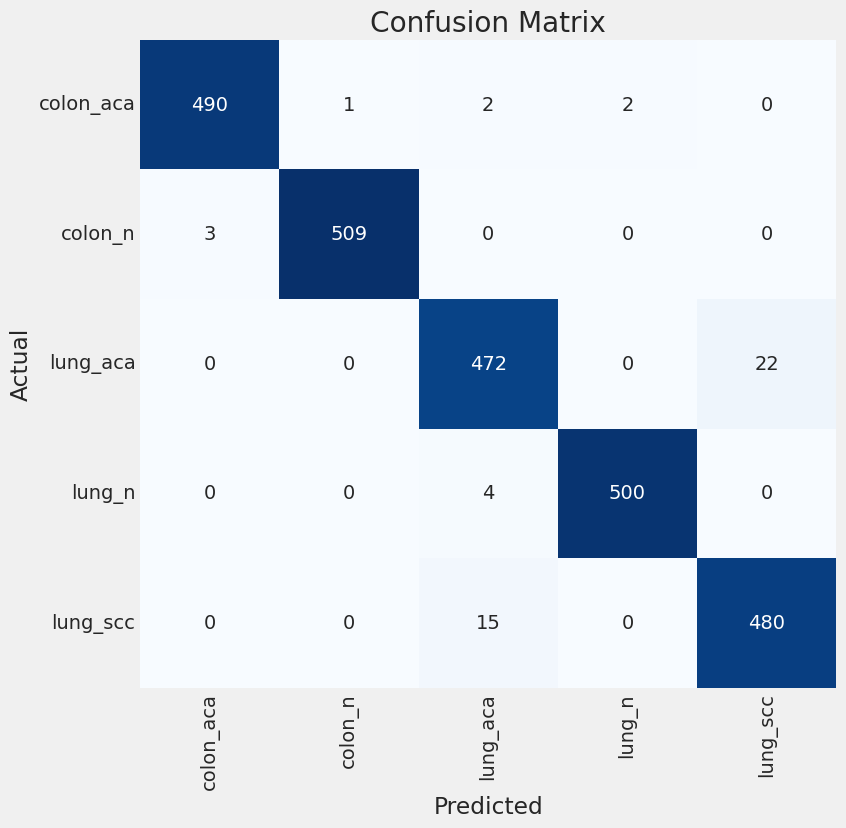

Classification Report:
----------------------
               precision    recall  f1-score   support

   colon_aca       0.99      0.99      0.99       495
     colon_n       1.00      0.99      1.00       512
    lung_aca       0.96      0.96      0.96       494
      lung_n       1.00      0.99      0.99       504
    lung_scc       0.96      0.97      0.96       495

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



In [20]:
print_code=20
print_info( test_gen, preds, print_code, save_dir, subject)